# test 3


In [116]:
import re,os,glob
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
# re patterns

base_dir=os.path.join("data/throughput/10k_complete")

matching_files = glob.glob(f"{base_dir}/*")

file_pattern= r'(\w+)_(\w+)_tT(\d+)_(\d+).data'

pub_pattern = r'cycles: (\d+) instruction: (\d+) start_ns: (\d+) end_ns: (\d+) start_s: (\d+) end_s: (\d+)'
sub_pattern = r'(\d+) received_s: (\d+) received_ns: (\d+)'

protocols=["udp","udpM","shm","tcp"]
sequence=[1,5,10,15,20,25,30,35,40]

# Calculate the IQR
def calculate_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

Difference r507n005 - r515n013 :(9091226, 673601595.0)
r507n005: (17180379, 527983166)
r515n013: (26271606,201584761.0)

new:
r507c02n02 len: 100
r507c01n03 len: 100
Difference r507c02n02 - r507c01n03 :(0, 227363132.19)
r507c02n02: (2135776, 622624310)
r507c01n03: (2135776,849987442.19)

In [117]:
# udp] pub_s = 17180379 pubns = 527983166 sub_s = 26271606 subns = 201584761
pub_s = 2135776 
pubns = 622624310 
sub_s = 2135776 
subns = 849987442.19


def timespec_difference_without_skew(start_s, start_ns, end_s, end_ns):
    s_diff = end_s - start_s
    ns_diff = end_ns - start_ns 
    if ns_diff < 0:
        ns_diff += 1e9
        s_diff -= 1
    return s_diff, ns_diff

# get difference in timespec
def timespec_difference(start_s_un, start_ns_un, end_s_un, end_ns_un):
    start_s,start_ns=timespec_difference_without_skew(pub_s,pubns,start_s_un,start_ns_un)
    end_s,end_ns=timespec_difference_without_skew(sub_s,subns, end_s_un, end_ns_un)

    s_diff = end_s - start_s
    ns_diff = end_ns - start_ns 
    if ns_diff < 0:
        ns_diff += 1e9
        s_diff -= 1
    return s_diff, ns_diff

## Retrive data

In [118]:
# for file_path in pub_matching_files:

sent_data={}
received_data={}
sent_data_time={}
for prot in protocols:
    sent_data[prot]={}
    received_data[prot]={}
    sent_data_time[prot]={}
    for seq in sequence:
        sent_data[prot][seq]=[]
        received_data[prot][seq]=[]
        sent_data_time[prot][seq]=[]

for files in matching_files:
    match_file = re.search(file_pattern, files)
    if match_file:
        actor,protocol,testN,subIndex = match_file.groups()
        if actor == "pub": #pubs
            with open(files, 'r') as file: 
                for line in file:
                    match = re.search(pub_pattern, line)
                    if match:
                        cycles, instruction, start_ns, end_ns, start_s, end_s = match.groups()
                        sent_data[protocol][int(testN)].append((int(cycles), int(instruction), int(start_s), int(start_ns), int(end_s), int(end_ns)))
                        s_diff, ns_diff = timespec_difference_without_skew(int(start_s), int(start_ns) , int(end_s) ,int(end_ns) )
                        sent_data_time[protocol][int(testN)].append((s_diff, ns_diff))
        else: # subs
            with open(files, 'r') as file: 
                for content in file:
                    match = re.search(sub_pattern, content)
                    if match:
                        line_n, received_s, received_ns = match.groups()
                        start_s,start_ns = ((sent_data[protocol][int(testN)][int(line_n)][2], sent_data[protocol][int(testN)][int(line_n)][3]))
                        if protocol == "shm":s_diff, ns_diff = timespec_difference_without_skew(start_s, start_ns , int(received_s), int(received_ns))
                        else:s_diff, ns_diff = timespec_difference(start_s, start_ns , int(received_s), int(received_ns))
                        received_data[protocol][int(testN)].append((s_diff, ns_diff))


### Cleaning data

In [129]:
column_time = {}
column_time_avg ={}
column_time_cleaned = {}
for prots in protocols:
    column_time[prots]={}
    column_time_cleaned[prots]={}
    column_time_avg[prots]={}
    for seq in sequence:
        list_difference=[]
        nlen= len(received_data[prots][seq])
        for cycle_data in received_data[prots][seq]:
            difference=cycle_data[0] * 1e6 + cycle_data[1] / 1e3
            list_difference.append(difference) # time in microsecond
        column_time[prots][seq]=list_difference
        #clean data
        try:
            lower_bound, upper_bound = calculate_iqr(column_time[prots][seq])
            column_time_cleaned[prots][seq] = [x for x in column_time[prots][seq] if lower_bound <= x <= upper_bound]
            column_time_avg[prots][seq]=np.average(column_time_cleaned[prots][seq])
            #print(column_time_avg[prots][seq])
        except: pass
    
column_timesent = {}
column_timesent_avg ={}
column_timesent_cleaned = {}
for prots in protocols:
    column_timesent[prots]={}
    column_timesent_cleaned[prots]={}
    column_timesent_avg[prots]={}
    for seq in sequence:
        list_difference=[]
        nlen= len(sent_data_time[prots][seq])
        for cycle_data in sent_data_time[prots][seq]:
            difference=cycle_data[0] * 1e6 + cycle_data[1] / 1e3
            list_difference.append(difference) # time in microsecond
        column_timesent[prots][seq]=list_difference
        #clean data
        try:
            lower_bound, upper_bound = calculate_iqr(column_timesent[prots][seq])
            column_timesent_cleaned[prots][seq] = [x for x in column_timesent[prots][seq] if lower_bound <= x <= upper_bound]
            column_timesent_avg[prots][seq]=np.average(column_timesent_cleaned[prots][seq])
            #print(column_time_avg[prots][seq])
        except: pass

# Sending-receive

### Sequence 1: only 1 pub 1 sub

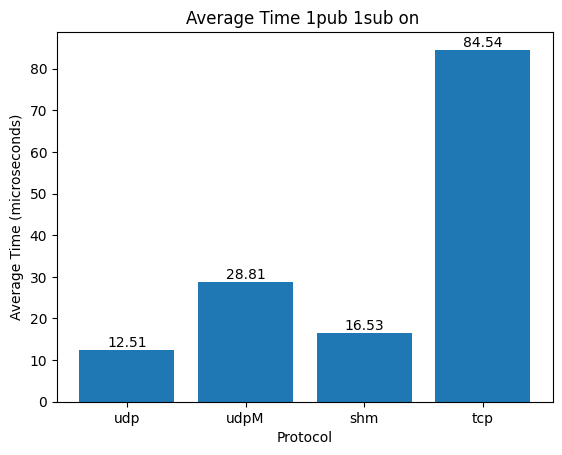

In [130]:
sequence_to_compare = 1
data_to_compare = {prots: column_time_cleaned[prots][sequence_to_compare] for prots in protocols}

average_times = [np.mean(data_to_compare[prots]) for prots in protocols]

fig, ax = plt.subplots()

bars = ax.bar(protocols, average_times)

for bar, value in zip(bars, average_times):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, f'{value:.2f}', ha='center', va='bottom')

ax.set_xlabel('Protocol')
ax.set_ylabel('Average Time (microseconds)')
ax.set_title(f'Average Time 1pub 1sub on ')

plt.show()


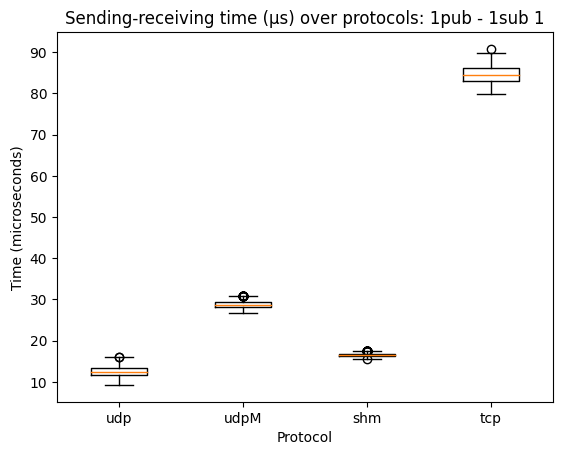

In [131]:
data_to_compare = {prots: column_time_cleaned[prots][sequence_to_compare] for prots in protocols}

data_list = [data_to_compare[prots] for prots in protocols]

fig, ax = plt.subplots()

ax.boxplot(data_list, labels=protocols)
ax.set_xlabel('Protocol')
ax.set_ylabel('Time (microseconds)')
ax.set_title(f'Sending-receiving time (μs) over protocols: 1pub - 1sub {sequence_to_compare}')
plt.show()



### All sequence

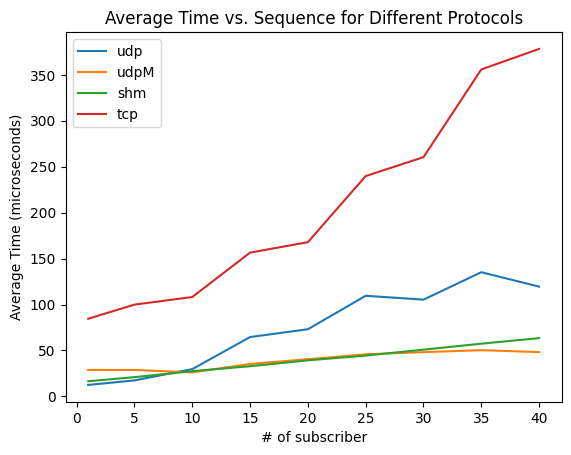

In [132]:
avg_data = {prots: [column_time_avg[prots][seq] for seq in sequence] for prots in protocols}

fig, ax = plt.subplots()
for prots in protocols:
    ax.plot(sequence, avg_data[prots], label=prots)
ax.set_xlabel('# of subscriber')
ax.set_ylabel('Average Time (microseconds)')
ax.set_title('Average Time vs. Sequence for Different Protocols')
ax.legend()

plt.show()

### udp vs udpM

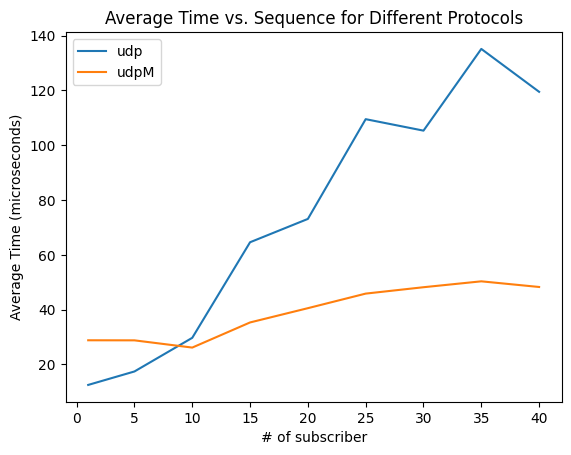

In [133]:
avg_data = {prots: [column_time_avg[prots][seq] for seq in sequence] for prots in ["udp","udpM"]}

fig, ax = plt.subplots()
for prots in ["udp","udpM"]:
    ax.plot(sequence, avg_data[prots], label=prots)
ax.set_xlabel('# of subscriber')
ax.set_ylabel('Average Time (microseconds)')
ax.set_title('Average Time vs. Sequence for Different Protocols')
ax.legend()

plt.show()

# Only send


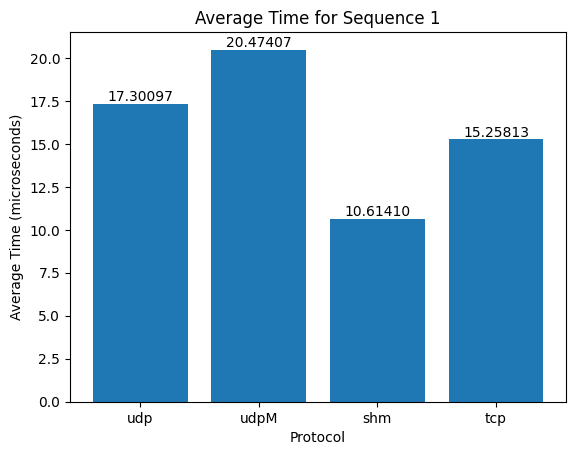

In [134]:
sequence_to_compare = 1
data_to_compare = {prots: column_timesent_cleaned[prots][sequence_to_compare] for prots in protocols}

average_times = [np.mean(data_to_compare[prots]) for prots in protocols]

fig, ax = plt.subplots()

bars = ax.bar(protocols, average_times)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.5f}', ha='center', va='bottom')

ax.set_xlabel('Protocol')
ax.set_ylabel('Average Time (microseconds)')
ax.set_title(f'Average Time for Sequence {sequence_to_compare}')

plt.show()

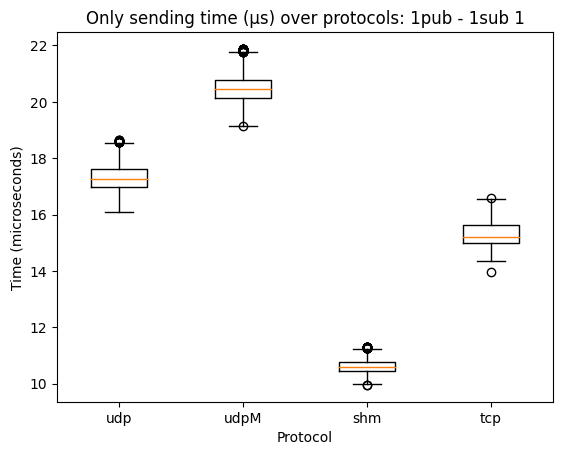

In [135]:
data_to_compare = {prots: column_timesent_cleaned[prots][sequence_to_compare] for prots in protocols}

data_list = [data_to_compare[prots] for prots in protocols]

fig, ax = plt.subplots()

ax.boxplot(data_list, labels=protocols)
ax.set_xlabel('Protocol')
ax.set_ylabel('Time (microseconds)')
ax.set_title(f'Only sending time (μs) over protocols: 1pub - 1sub {sequence_to_compare}')
plt.show()        

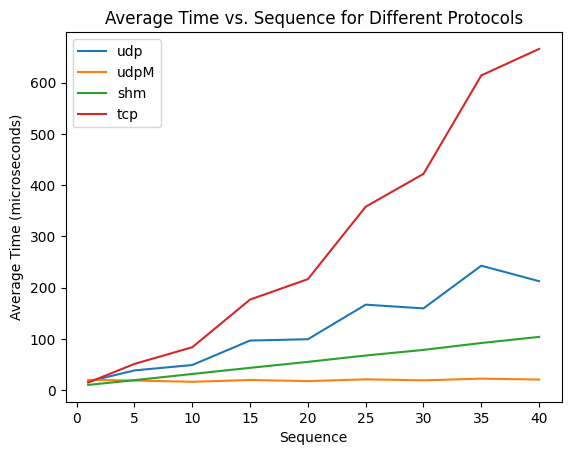

In [136]:
avg_data = {prots: [column_timesent_avg[prots][seq] for seq in sequence] for prots in protocols}

fig, ax = plt.subplots()
for prots in protocols:
    ax.plot(sequence, avg_data[prots], label=prots)
ax.set_xlabel('Sequence')
ax.set_ylabel('Average Time (microseconds)')
ax.set_title('Average Time vs. Sequence for Different Protocols')
ax.legend()

plt.show()